In [1]:
import fitsio
import numpy as np
import galsim
import scipy.ndimage
import tqdm

In [2]:
def _wrap_ravec(ras):
    cen = ras[0]
    dras = ras-cen
    msk = dras > 180.0
    if np.any(msk):
        dras[msk] = dras[msk] - 360.0
        
    msk = dras < -180.0
    if np.any(msk):
        dras[msk] = dras[msk] + 360.0    
    
    return dras, cen

dtype = [
    ("expnum", "i8"),
    ("mjd_obs", "f8"),
    ("band", "U1"),
    ("ra", "f8"),
    ("dec", "f8"),
]

def _munge_file(fname):
    d = fitsio.read(fname)
    msk = (d["CCDNUM"] == 28) | (d["CCDNUM"] == 35)
    d = d[msk]
    
    low_expnum = np.min(d["EXPNUM"])
    revind = scipy.ndimage.value_indices(d["EXPNUM"]-low_expnum)
    
    ed = np.zeros(len(revind), dtype=dtype)
    for ind, (k, v) in enumerate(revind.items()):
        assert np.all(d["MJD_OBS"][v] == d["MJD_OBS"][v][0])
        assert np.all(d["BAND"][v] == d["BAND"][v][0])
        ed["expnum"][ind] = k + low_expnum
        ed["mjd_obs"][ind] = d["MJD_OBS"][v][0]
        ed["band"][ind] = d["BAND"][v][0]
        _d = d[v]
        uccd, uccdi, uccdc = np.unique(_d["CCDNUM"], return_inverse=True, return_counts=True)
        wgt = (1.0/uccdc)[uccdi]
        wgt = wgt / np.sum(wgt)
        
        rav, cen = _wrap_ravec(_d["RA_CENT"])
        ed["ra"][ind] = np.sum(wgt * rav) + cen
        ed["dec"][ind] = np.sum(wgt * _d["DEC_CENT"])
#         print(_d["RA_CENT"], rav, cen, wgt, ed["ra"][ind])
#         print(d["MJD_OBS"][v])
#         print(d["BAND"][v])
#         print(d["CCDNUM"][v], wgt)
#         print(_d["RA_CENT"], _d["DEC_CENT"])
#         break
    return ed

In [3]:
import glob

fnames = glob.glob("y6a2_coadd_input_image_table_*.fits")
ed = np.concatenate([_munge_file(fname) for fname in tqdm.tqdm(fnames, ncols=80)], axis=0)

100%|█████████████████████████████████████████████| 6/6 [00:51<00:00,  8.63s/it]


In [4]:
import proplot as pplt

%matplotlib inline

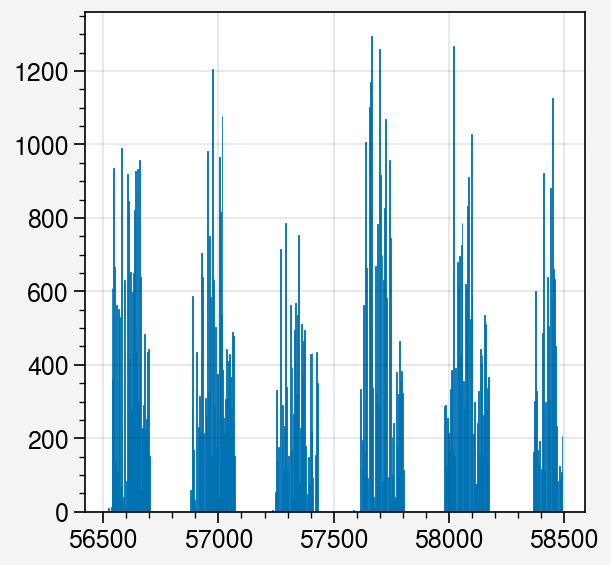

In [5]:
fig, axs = pplt.subplots()

axs.hist(ed["mjd_obs"], bins=500);

In [6]:
fitsio.write("des_exposure_data.fits", ed, clobber=True)

<a list of 1 Line2D objects>

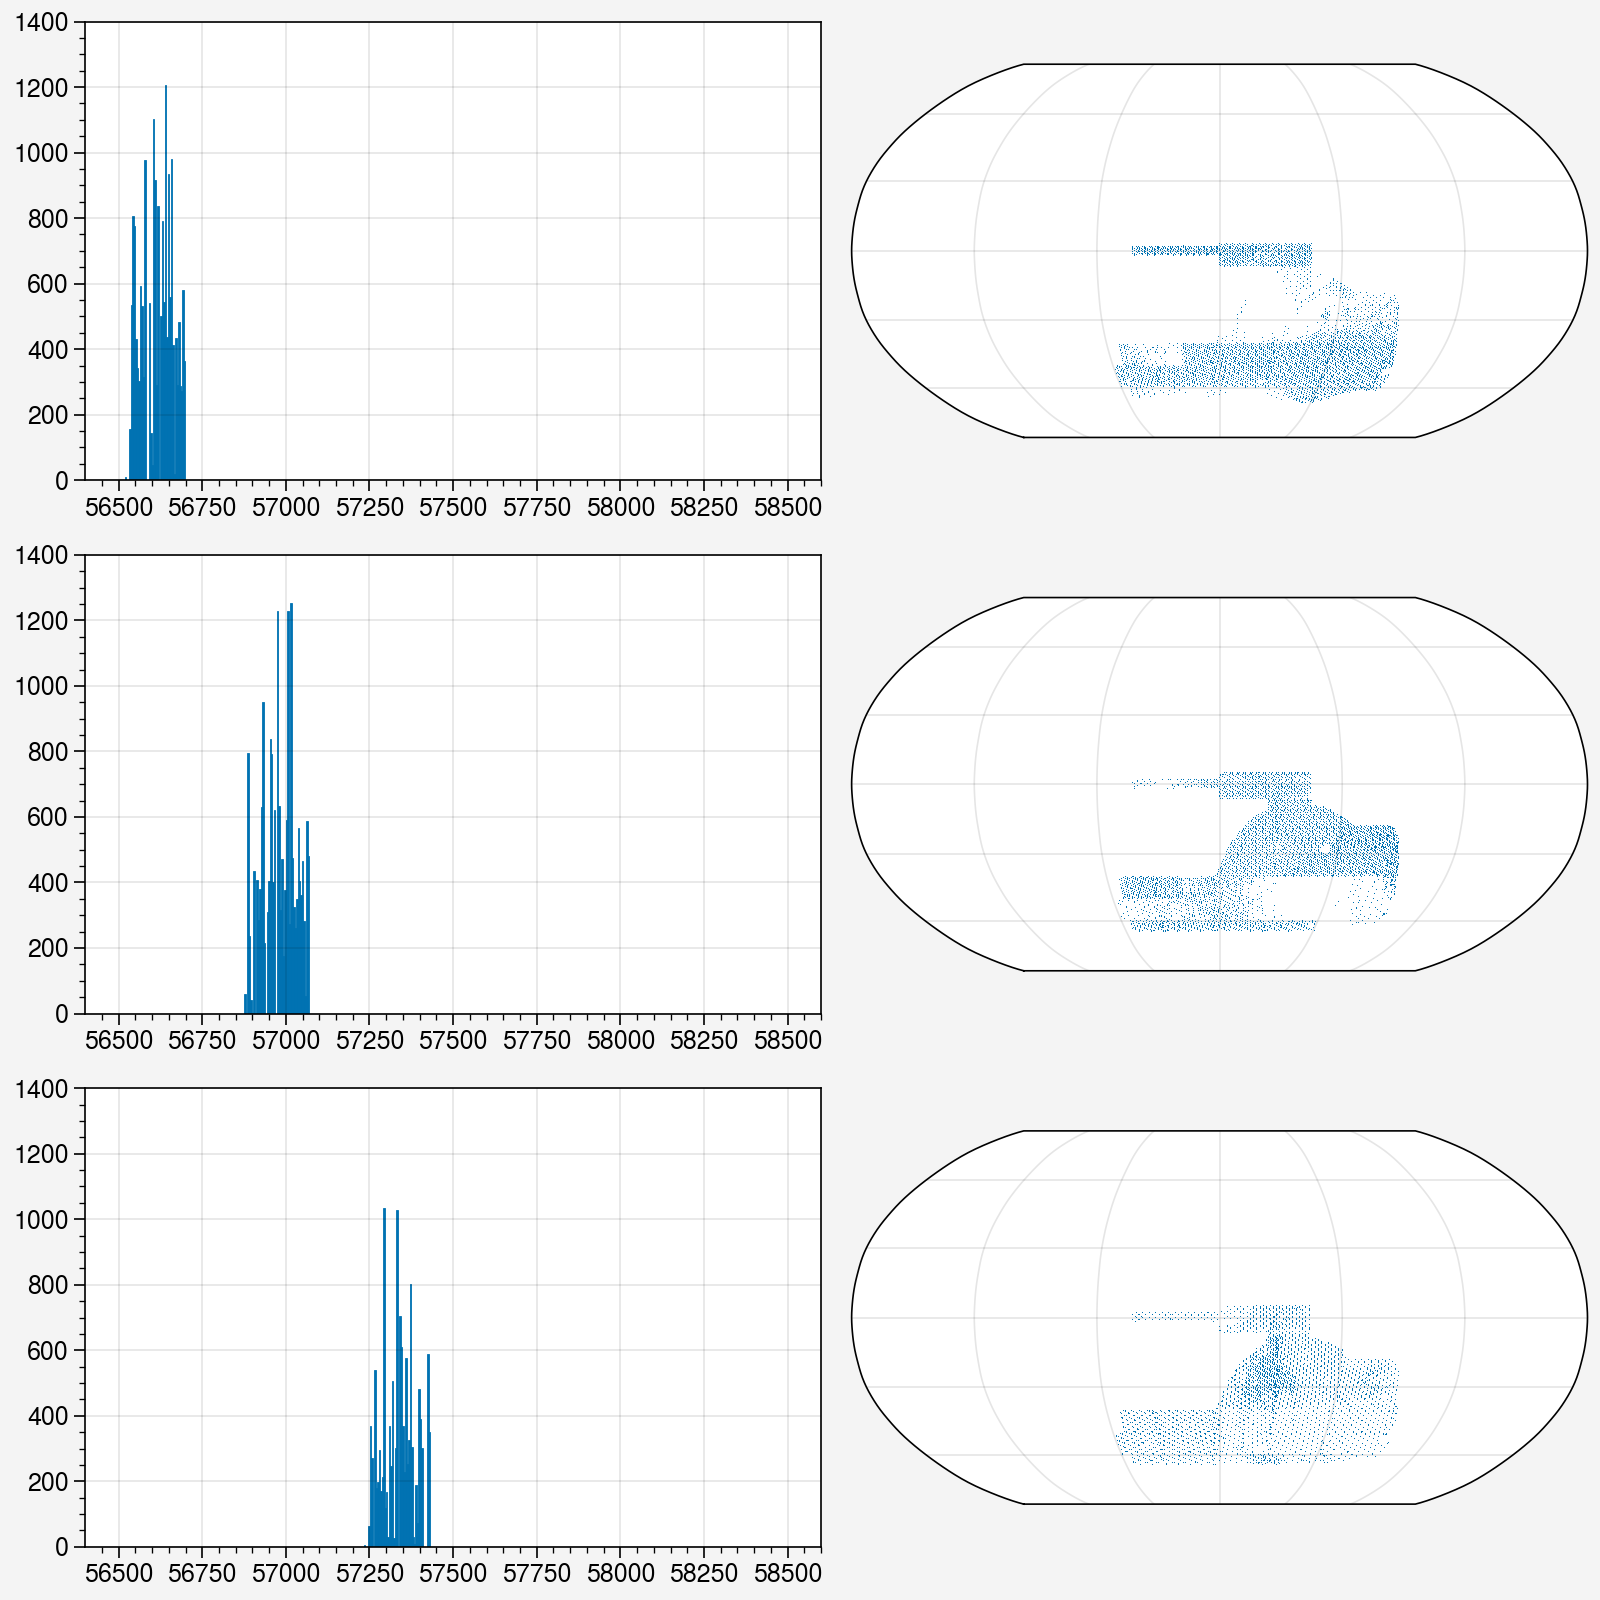

In [21]:
fig, axs = pplt.subplots(nrows=3, ncols=2, share=0, proj={(2, 4, 6): "robin"}, figsize=(8, 8))

msk = (ed["mjd_obs"] < 56750)

axs[0, 0].hist(ed["mjd_obs"][msk], bins=np.linspace(56400, 58600, 500))
axs[0, 0].format(xlim=(56400, 58600), ylim=(0, 1400))

axs[0, 1].plot(ed["ra"][msk], ed["dec"][msk], ",")

msk = (ed["mjd_obs"] > 56750) & (ed["mjd_obs"] < 57200)

axs[1, 0].hist(ed["mjd_obs"][msk], bins=np.linspace(56400, 58600, 500))
axs[1, 0].format(xlim=(56400, 58600), ylim=(0, 1400))

axs[1, 1].plot(ed["ra"][msk], ed["dec"][msk], ",")

msk = (ed["mjd_obs"] > 57200) & (ed["mjd_obs"] < 57500)

axs[2, 0].hist(ed["mjd_obs"][msk], bins=np.linspace(56400, 58600, 500))
axs[2, 0].format(xlim=(56400, 58600), ylim=(0, 1400))

axs[2, 1].plot(ed["ra"][msk], ed["dec"][msk], ",")

In [ ]:
fig, axs = pplt.subplots(nrows=3, ncols=2, share=0)

msk = (ed["mjd_obs"] > 57500) & (ed["mjd_obs"] < 57900)

axs[0, 0].hist(ed["mjd_obs"][msk], bins=np.linspace(56400, 58600, 500))
axs[0, 0].format(xlim=(56400, 58600), ylim=(0, 1400))

axs[0, 1].hexbin(ed["ra"][msk], ed["dec"][msk])
axs[0, 1].format(xlim=(0, 360))

msk = (ed["mjd_obs"] > 57900) & (ed["mjd_obs"] < 58300)

axs[1, 0].hist(ed["mjd_obs"][msk], bins=np.linspace(56400, 58600, 500))
axs[1, 0].format(xlim=(56400, 58600), ylim=(0, 1400))

axs[1, 1].hexbin(ed["ra"][msk], ed["dec"][msk])
axs[1, 1].format(xlim=(0, 360))

msk = (ed["mjd_obs"] > 58300)

axs[2, 0].hist(ed["mjd_obs"][msk], bins=np.linspace(56400, 58600, 500))
axs[2, 0].format(xlim=(56400, 58600), ylim=(0, 1400))

axs[2, 1].hexbin(ed["ra"][msk], ed["dec"][msk])
axs[2, 1].format(xlim=(0, 360))

In [ ]:
import matplotlib; print(matplotlib.__version__); import proplot; print(proplot.version) 